/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Norm stats (0.31651367646535716, 0.3892634560571173)
torch.Size([2, 5, 120, 120])


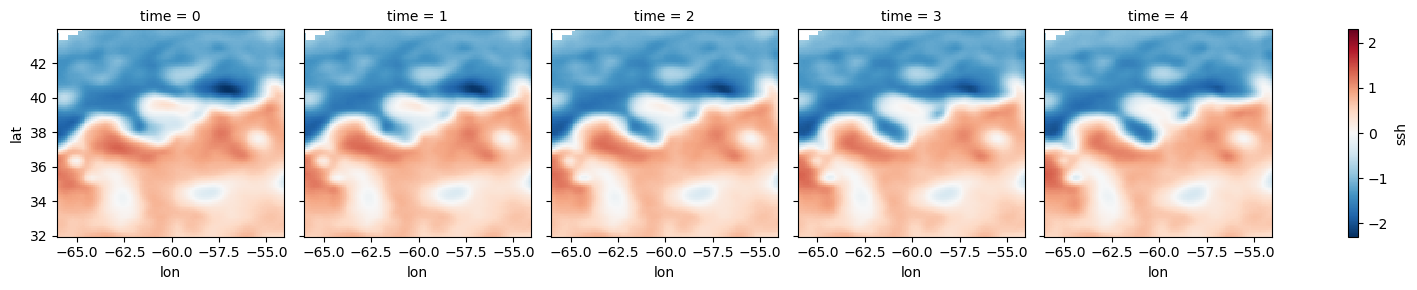

In [1]:
import sys
sys.path.append('..')
from src.data_notebook_woi import *
from src.utils import *
from src.models import *
from contrib.stoch_spde.lit_model_spde import *
from contrib.stoch_spde.models_spde import *
#from contrib.stoch_spde.solver import *
#from contrib.stoch_spde.unet import *

def spspmm(A,B):
    return torch.sparse.mm(A,B)

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66 
lon_max = -54
#lon_max = -63
lat_min = 32
lat_max = 44
#lat_max = 35

datamodule = BaseDataModule(input_da=load_altimetry_data_woi("/DATASET/mbeauchamp/natl_gf_w_5nadirs_swot_woi.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-01', '2012-12-20',)}},
                            xrds_kw={'patch_dims': {'time': 5, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 120, 'lon': 120},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2, grad=False)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].oi)},
           coords={'time':np.arange(5),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

# Define the solver

## 1. BilinAE

In [2]:
class BilinAEPriorCost(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, downsamp=None, bilin_quad=True, nt=None):
        super().__init__()
        self.nt = nt
        self.bilin_quad = bilin_quad
        self.conv_in = nn.Conv2d(
            dim_in, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.bilin_1 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_21 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_22 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.conv_out = nn.Conv2d(
            2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def forward_ae(self, x):
        x = self.down(x)
        x = self.conv_in(x)
        x = self.conv_hidden(F.relu(x))

        nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x) * self.bilin_22(x))
        x = self.conv_out(
            torch.cat([self.bilin_1(x), nonlin], dim=1)
        )
        x = self.up(x)
        return x

    def forward(self, state, exclude_params=False):
        if not exclude_params:
            return F.mse_loss(state, self.forward_ae(state))
        else:
            return F.mse_loss(state[:,:self.nt,:,:], self.forward_ae(state)[:,:self.nt,:,:])

## 2. PriorNet

In [3]:
class PriorNet(torch.nn.Module):
    def __init__(self, dim_in,  dim_hidden, nparam, kernel_size=3, downsamp=None):

        super().__init__()

        self.nt = dim_in
        self.nparam = nparam
        self.dim_param = self.nt * nparam
        #self.dim_hidden_param = dim_hidden*self.dim_param
        self.dim_hidden_param = 100
        self.bilin_quad = False

        # state estimation
        self.conv_in = torch.nn.Conv2d(
            dim_in, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden = torch.nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_1 = torch.nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_21 = torch.nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_22 = torch.nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_out = torch.nn.Conv2d(
            2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        # parameter estimation
        self.conv_in_param = torch.nn.Conv2d(
            self.dim_param, self.dim_hidden_param, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden_param = torch.nn.Conv2d(
            self.dim_hidden_param, self.dim_hidden_param, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.add_grad_info = torch.nn.Conv2d(
            self.dim_hidden_param + 3*self.nt, self.dim_hidden_param, kernel_size=kernel_size, padding=kernel_size // 2
        )

        # rebuild the augmented state
        self.aug_conv_out = torch.nn.Conv2d(
            dim_in + self.dim_hidden_param, dim_in + self.dim_param, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.down = torch.nn.AvgPool2d(downsamp) if downsamp is not None else torch.nn.Identity()
        self.up = (
            torch.nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else torch.nn.Identity()
        )

    def forward(self, state):

        n_b, _, n_y, n_x = state.shape
        state = self.down(state)

        # state estimation
        x = self.conv_in(state[:,:self.nt,:,:])
        x = self.conv_hidden(F.relu(x))
        nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x) * self.bilin_22(x))
        x = self.conv_out(
            torch.cat([self.bilin_1(x), nonlin], dim=1)
        )

        # parameter estimation
        theta = self.conv_in_param(state[:,self.nt:,:,:])
        theta = self.conv_hidden_param(F.relu(theta))
        theta = self.add_grad_info(torch.cat([x, 
                                              torch.reshape(kfilts.spatial_gradient(x,normalized=True),
                                                            (n_b, 2*self.nt, n_y, n_x)),
                                              theta], dim=1))

        # final state
        state = self.aug_conv_out(
            torch.cat([x, theta], dim=1)
        )
        state = self.up(state)
        return state

class AugPriorCost(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden, nparam, kernel_size=3, downsamp=None):

        super().__init__()
        self.nt = dim_in
        self.priornet = PriorNet(dim_in, dim_hidden, nparam, kernel_size, downsamp)

    def forward_ae(self, x):
        x = self.priornet(x)
        return x

    def forward(self, state, exclude_params=False):
        if not exclude_params:
            return F.mse_loss(state, self.forward_ae(state))
        else:
            return F.mse_loss(state[:,:self.nt,:,:], self.forward_ae(state)[:,:self.nt,:,:])

## 3. Solver

In [26]:
### import pandas as pd
import einops
from pathlib import Path
import pytorch_lightning as pl
import kornia.filters as kfilts
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GradSolver_Lgv(nn.Module):
    def __init__(self, nll, nlpobs, prior_cost, obs_cost, grad_mod, n_step,
                 lr_grad=0.2, exclude_params=False, aug_state="x",  unet_prior=False, **kwargs):
        super().__init__()
        self.nll = nll
        self.nlpobs = nlpobs
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.unet_prior = unet_prior
        self.grad_mod = grad_mod
        self.n_step = n_step
        self.lr_grad = lr_grad
        self.exclude_params = exclude_params
        self._grad_norm = None
        self.aug_state = aug_state
        self.lambda_obs = torch.nn.Parameter(torch.Tensor([1.]))
        self.lambda_reg = torch.nn.Parameter(torch.Tensor([1.]))
    
    def init_state(self, batch, x_init=None):
        
        if self.aug_state=="x":
            if x_init is not None:
                return x_init
            else:
                return batch.input.nan_to_num().detach().requires_grad_(True)
        elif self.aug_state=="theta":
            kappa_init = torch.ones(batch.input.size()).to(device)*0.1
            tau_init = torch.ones(batch.input.size()).to(device)*0.1
            m1_init = torch.ones(batch.input.size()).to(device)*0.1
            m2_init = torch.ones(batch.input.size()).to(device)*0.1
            vx_init = torch.zeros(batch.input.size()).to(device)
            vy_init = torch.zeros(batch.input.size()).to(device)
            gamma_init = torch.ones(batch.input.size()).to(device)
            beta_init = torch.zeros(batch.input.size()).to(device)        
            state_init =  torch.cat((kappa_init,
                                tau_init,
                                m1_init,
                                m2_init,
                                vx_init,
                                vy_init,
                                gamma_init,
                                beta_init),dim=1).requires_grad_(True)
            return state_init            
        else:
            kappa_init = torch.ones(batch.input.size()).to(device)*0.1
            tau_init = torch.ones(batch.input.size()).to(device)*1
            #tau_init =  2*(torch.abs(kfilts.spatial_gradient(x_init,normalized=True)[:,:,1,:,:]))+.01
            m1_init = torch.ones(batch.input.size()).to(device)*0.1
            m2_init = torch.ones(batch.input.size()).to(device)*0.1
            vx_init = torch.zeros(batch.input.size()).to(device)
            vy_init = torch.zeros(batch.input.size()).to(device)
            gamma_init = torch.ones(batch.input.size()).to(device)
            beta_init = torch.zeros(batch.input.size()).to(device)
            if x_init is None:
                x_init = batch.input.nan_to_num().detach()
            state_init =  torch.cat((x_init,
                                kappa_init,
                                tau_init,
                                m1_init,
                                m2_init,
                                vx_init,
                                vy_init,
                                gamma_init,
                                beta_init),dim=1).requires_grad_(True)
            return state_init

    def solver_step(self, state, batch, step, mu=None, noise=False, x_pred=None):
        device = state.device
        n_b, n_t, n_y, n_x = batch.input.shape
        if self.aug_state=="x":
            x = state
            theta = None
        elif self.aug_state=="theta":
            x = x_pred.to(device)
            theta = state
        else:
            x = state[:,:n_t,:,:]
            theta = state[:,n_t:,:,:]
        if self.aug_state=="x":
            grad_logp = self.lambda_obs**2 * self.obs_cost(x, batch) +\
                        self.lambda_reg**2 * self.prior_cost(state,exclude_params=self.exclude_params) 
        elif self.aug_state=="theta":
            if not self.unet_prior:
                grad_logp = torch.nanmean((-1) * self.nll(x, state, mu=mu, det=False))
            else:
                grad_logp = self.prior_cost(torch.cat((x,state),dim=1)) 
        else:
            if not self.unet_prior:
                grad_logp = torch.nanmean(self.lambda_obs**2 * self.nlpobs(x,batch)+ \
                                          self.lambda_reg**2 * (-1) * self.nll(x, theta, mu=mu, det=False))
            else: 
                grad_logp = self.lambda_obs**2 * self.obs_cost(x, batch) +\
                            self.lambda_reg**2 * self.prior_cost(state,exclude_params=self.exclude_params) 

        grad = torch.autograd.grad(grad_logp, state, create_graph=True)[0]

        # B,t,x,y -> b,t,y,x
        # add noise
        if noise:
            noise = torch.randn(grad.size(),requires_grad=True).to(device) #* self.lr_grad
            gmod = self.grad_mod(grad + noise)
        else:
            gmod = self.grad_mod(grad)
        state_update = (
            1 / (step + 1) * gmod
                + self.lr_grad * (step + 1) / self.n_step * grad
        )
        state_update = 1 / (step + 1) * gmod

        res = state - state_update #+ noise

        # constrain theta
        if self.aug_state!="x":
            if self.aug_state=="x_theta":
                idx_kappa = torch.arange(n_t,2*n_t)
                idx_tau = torch.arange(2*n_t,3*n_t)
                idx_m1 = torch.arange(3*n_t,4*n_t)
                idx_m2 = torch.arange(4*n_t,5*n_t)
                idx_vx = torch.arange(5*n_t,6*n_t)
                idx_vy = torch.arange(6*n_t,7*n_t)
                idx_gamma = torch.arange(7*n_t,8*n_t)
                idx_beta = torch.arange(8*n_t,9*n_t)
            if self.aug_state=="theta":
                idx_kappa = torch.arange(0,n_t)
                idx_tau = torch.arange(n_t,2*n_t)
                idx_m1 = torch.arange(2*n_t,3*n_t)
                idx_m2 = torch.arange(3*n_t,4*n_t)
                idx_vx = torch.arange(4*n_t,5*n_t)
                idx_vy = torch.arange(5*n_t,6*n_t)
                idx_gamma = torch.arange(6*n_t,7*n_t)
                idx_beta = torch.arange(7*n_t,8*n_t)
            
            kappa = res[:,idx_kappa,:,:]
            tau = res[:,idx_tau,:,:]
            m1 = res[:,idx_m1,:,:]
            m2 = res[:,idx_m2,:,:]
            vx = res[:,idx_vx,:,:]
            vy = res[:,idx_vy,:,:]
            gamma = res[:,idx_gamma,:,:]
            beta = res[:,idx_beta,:,:]
            
            # parameters: gamma > 0
            gamma = res[:,idx_gamma,:,:]
            gamma =  F.relu(gamma)+.01
            res = torch.index_add(res,1,idx_gamma.to(device),-1*res[:,idx_gamma,:,:])
            res = torch.index_add(res,1,idx_gamma.to(device),gamma)

            # parameters: beta > 0
            beta = res[:,idx_beta,:,:]
            beta =  F.relu(beta)+.01  
            res = torch.index_add(res,1,idx_beta.to(device),-1*res[:,idx_beta,:,:])
            res = torch.index_add(res,1,idx_beta.to(device),beta)             
            
            # parameters: kappa > 0
            #kappa = torch.clamp(F.relu(kappa), min=.01, max=.33)
            #kappa = torch.clamp(F.leaky_relu(kappa, negative_slope=-0.01)+0.01, min=.01, max=.33)
            kappa = F.relu(kappa)+.01
            res = torch.index_add(res,1,idx_kappa.to(device),-1*res[:,idx_kappa,:,:])
            res = torch.index_add(res,1,idx_kappa.to(device),kappa)

            # parameters: tau > 0
            tau = F.relu(tau)+.1
            #tau = F.leaky_relu(tau, negative_slope=-0.01)+0.01 
            res = torch.index_add(res,1,idx_tau.to(device),-1*res[:,idx_tau,:,:])
            res = torch.index_add(res,1,idx_tau.to(device),tau)
            
        return res
        
    def forward(self, batch, x_init = None, mu=None, reshape_theta=True, x_pred=None):

        device = batch.input.device
        n_t = batch.input.size(1)
        
        with torch.set_grad_enabled(True):
            state = self.init_state(batch, x_init=x_init)
            self.grad_mod.reset_state(batch.input)

            for step in range(self.n_step):
                state = self.solver_step(state, batch, mu=mu, step=step, x_pred=x_pred)
                if not self.training:
                    state = state.detach().requires_grad_(True)

        if self.aug_state=="x":
            theta = None
        elif self.aug_state=="theta":
            theta = state
            state = None
            if reshape_theta:
                kappa, m, H, tau = self.nll.reshape_params(theta)
                theta = [kappa, m, H, tau]                                              
        else:
            theta = state[:,n_t:,:,:]
            state = state[:,:n_t,:,:]
            if reshape_theta:
                kappa, m, H, tau = self.nll.reshape_params(theta)
                theta = [kappa, m, H, tau]
        
        return state, theta

class ConvLstmGradModel(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, dropout=0.1, downsamp=None):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.gates = torch.nn.Conv2d(
            dim_in + dim_hidden,
            4 * dim_hidden,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )

        self.dropout = torch.nn.Dropout(dropout)
        self.conv_out = torch.nn.Conv2d(
            dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self._state = []
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def reset_state(self, inp):
        size = [inp.shape[0], self.dim_hidden, *inp.shape[-2:]]
        self._grad_norm = None
        self._state = [
            self.down(torch.zeros(size, device=inp.device)),
            self.down(torch.zeros(size, device=inp.device)),
        ]

    def forward(self, x):
        if self._grad_norm is None:
            self._grad_norm = (x**2).mean().sqrt()
        x =  x / self._grad_norm
        hidden, cell = self._state
        x = self.dropout(x)
        x = self.down(x)
        gates = self.gates(torch.cat((x, hidden), 1))

        in_gate, remember_gate, out_gate, cell_gate = gates.chunk(4, 1)

        in_gate, remember_gate, out_gate = map(
            torch.sigmoid, [in_gate, remember_gate, out_gate]
        )
        cell_gate = torch.tanh(cell_gate)

        cell = (remember_gate * cell) + (in_gate * cell_gate)
        hidden = out_gate * torch.tanh(cell)

        self._state = hidden, cell
        out = self.conv_out(hidden)
        out = self.up(out)
        return out

## 4. NLL

In [27]:
def sparse_eye(size, val = torch.tensor(1.0)):
    """
    Returns the identity matrix as a sparse matrix
    """
    indices = torch.arange(0, size).long().unsqueeze(0).expand(2, size).to(device)
    if len(val.size())==0:
        values = (val.expand(size)).to(device)
    else:
        values = val.to(device)
    cls = getattr(torch.sparse, values.type().split(".")[-1])
    return cls(indices, values, torch.Size([size, size])).to(device)

def sparse_repeat(size,n1,n2):
    """
    Returns a sparse zero-filled tensor repeating 
    a 2D size*size sparse zero-filled tensor
    n1 times along dim1 and n2 times along n2
    """
    return torch.sparse.LongTensor(size*n1,size*n2).to(device)


class Encoder(torch.nn.Module):

    def __init__(self,shape_data):
        super(Encoder, self).__init__()
        self.n_t, self.n_y, self.n_x  = shape_data
        self.cnn = torch.nn.Conv2d(self.n_t,8*self.n_t,(3,3),padding=1,bias=False)

    def forward(self, x):
        # input shape (b,t,y,x) --> output shape (b,7*t,y,x)
        theta = self.cnn(x)
        # activation functions on some parameters
        return theta

class NLL_new(torch.nn.Module):

    def __init__(self, shape_data, st_lag=[1,1,1], trainable_lag=False,
                 pow=1, spde_type="adv_diff", scheme="FUDM1",crop=None, downsamp=None):

        super(NLL_new,self).__init__()
        self.spde_type = spde_type
        self.scheme = scheme
        self.pow = pow        
        self.crop = crop
        self.downsamp = downsamp
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )
        self.trainable_lag = trainable_lag
        if crop is not None:
            shape_data = [shape_data[0],
                          shape_data[1]-self.crop,
                          shape_data[2]-self.crop]
            
        if downsamp is not None:
            shape_data = [shape_data[0],
                          shape_data[1]//self.downsamp,
                          shape_data[2]//self.downsamp] 
        
        self.encoder = Encoder(shape_data)
        
        self.operator_spde = Prior_SPDE(shape_data,st_lag,
                                        trainable_lag=self.trainable_lag,
                                        pow=self.pow,
                                        spde_type=self.spde_type,
                                        scheme=self.scheme)
        
    def custom_sigmoid(self,x,min,max):
        add_const = min/(max-min)
        mult_const = max-min
        return (torch.sigmoid(x)+add_const)*mult_const
        
    def reshape_params(self,theta):

        n_b, n_t, n_x, n_y = theta.shape
        n_t = theta.shape[1]//8

        # reshape the parameters
        kappa = theta[:,:n_t,:,:]
        tau = theta[:,n_t:2*n_t,:,:]
        m1 = theta[:,2*n_t:3*n_t,:,:]
        m2 = theta[:,3*n_t:4*n_t,:,:]
        vx = theta[:,4*n_t:5*n_t,:,:]
        vy = theta[:,5*n_t:6*n_t,:,:]
        gamma = theta[:,6*n_t:7*n_t,:,:]
        beta = theta[:,7*n_t:8*n_t,:,:]
        
        H = []
        for k in range(n_t):
            vx_ = torch.reshape(vx[:,k,:,:],(n_b,n_x*n_y))
            vy_ = torch.reshape(vy[:,k,:,:],(n_b,n_x*n_y))
            vxy = torch.stack([vx_,vy_],dim=2)
            vxyT = torch.permute(vxy,(0,2,1))
            gamma_ = torch.reshape(gamma[:,k,:,:],(n_b,n_x*n_y))
            beta_ = torch.reshape(beta[:,k,:,:],(n_b,n_x*n_y))
            H_ = torch.einsum('ij,bk->bijk',
                              torch.eye(2).to(device),
                              gamma_)+\
                 torch.einsum('bk,bijk->bijk',beta_,torch.einsum('bki,bjk->bijk',vxy,vxyT))
            H.append(H_)
        H = torch.stack(H,dim=4)
        m = torch.stack([m1,m2],dim=1)

        kappa = torch.permute(kappa,(0,2,3,1))
        tau = torch.permute(tau,(0,2,3,1))
        m = torch.permute(m,(0,1,3,4,2))
        H = torch.reshape(H,(n_b,2,2,n_x,n_y,n_t))
        H = torch.permute(H,(0,1,2,3,4,5))

        # reshaping n_x,n_y -> n_x*n_y
        kappa = torch.reshape(kappa,(n_b,1,n_y*n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y*n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y*n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y*n_x,n_t))

        #H = torch.full(H.shape,0.).to(device)
        return [kappa, m, H, tau]
    
    def downsamp_params(self, kappa, m, H, tau, sp_dims):
        
        n_b, _, nb_nodes, n_t = m.shape
        n_x, n_y = sp_dims
        
        kappa = torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y,n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y,n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))
        
        kappa = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(kappa[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)
        tau = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(tau[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)    
        m1 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(m[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m2 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(m[:,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m = torch.cat([m1,m2],dim=1)
        h11 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,0,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h12 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,0,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h22 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,1,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        H = torch.reshape(torch.cat([h11,h12,h12,h22],dim=1),(n_b,2,2,n_y//self.downsamp,n_x//self.downsamp,n_t))
        
        kappa = torch.reshape(kappa,(n_b,1,nb_nodes//(self.downsamp**2),n_t))
        tau = torch.reshape(tau,(n_b,1,nb_nodes//(self.downsamp**2),n_t))
        m = torch.reshape(m,(n_b,2,nb_nodes//(self.downsamp**2),n_t))
        H = torch.reshape(H,(n_b,2,2,nb_nodes//(self.downsamp**2),n_t))
        
        return kappa, m, H, tau
    
    def upsamp_params(self, kappa, m, H, tau, sp_dims):
        
        n_b, _, nb_nodes, n_t = m.shape
        n_x, n_y = sp_dims
        
        kappa = torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y,n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y,n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))
        
        kappa = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(kappa[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)
        tau = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(tau[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)    
        m1 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(m[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m2 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(m[:,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m = torch.cat([m1,m2],dim=1)
        h11 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,0,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h12 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,0,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h22 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,1,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        H = torch.reshape(torch.cat([h11,h12,h12,h22],dim=1),(n_b,2,2,int(n_y*self.downsamp),
                                                                      int(n_x*self.downsamp),n_t))

        kappa = torch.reshape(kappa,(n_b,1,int(nb_nodes*(self.downsamp**2)),n_t))
        tau = torch.reshape(tau,(n_b,1,int(nb_nodes*(self.downsamp**2)),n_t))
        m = torch.reshape(m,(n_b,2,int(nb_nodes*(self.downsamp**2)),n_t))
        H = torch.reshape(H,(n_b,2,2,int(nb_nodes*(self.downsamp**2)),n_t))
        
        return kappa, m, H, tau
    

    def forward(self, x, theta=None, mu=None, det=True):

        n_b, n_t, n_x, n_y = x.shape

        # compute the parameters
        if theta is None:
            theta = self.encoder(x)
            
        if not isinstance(theta, list):
            kappa, m, H, tau = self.reshape_params(theta)
        else:
            kappa, m, H, tau = theta
        
        # compute Q(theta)
        if self.crop is not None:
            c = self.crop//2
            x = x[:,:,c:-c,c:-c]
            if mu is not None:
                mu = mu[:,:,c:-c,c:-c]
            kappa = torch.reshape(torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            tau = torch.reshape(torch.reshape(tau,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            m = torch.reshape(torch.reshape(m,(n_b,2,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            H = torch.reshape(torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))[:,:,:,c:-c,c:-c,:],
                                   (n_b,2,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            n_b, n_t, n_y, n_x = x.shape
            
        if self.downsamp is not None:
            kappa, m, H, tau = self.downsamp_params(kappa, m, H, tau, sp_dims=[n_y, n_x])
            
        Q, block_diag = self.operator_spde(kappa,
                                           m,
                                           H,
                                           tau,
                                           store_block_diag=True)
        
        # compute determinant(Q)
        if det==True:
            det_Q = list()
            for i in range(n_b):
                log_det = 0.
                for j in range(0,len(block_diag[i])):
                    BD = block_diag[i][j].to_dense().to(device)#.type(torch.LongTensor)
                    #chol_block = torch.linalg.cholesky(BD)
                    chol_block, info = torch.linalg.cholesky_ex(BD)
                    if info!=0:
                        return torch.tensor([np.nan for _ in range(n_b)])
                    log_det_block =  2*torch.sum(\
                                         torch.log(\
                                         torch.diagonal(\
                                         chol_block,
                                         0)\
                                        )\
                                       )
                    log_det += log_det_block
                # log(det(Q^k)) = sum_k=1^p log(det(Q))
                #log_det = int(2*self.pow)*log_det
                det_Q.append(log_det)

        # compute Mahanalobis distance xT.Q.x
        MD = list()
        for i in range(n_b):
            if self.downsamp is None:
                if mu is None:
                    MD_ = sp_mm(Q[i],torch.reshape(x[i],(n_t*n_x*n_y,1)))
                    MD_ = torch.matmul(torch.reshape(x[i],(1,n_t*n_x*n_y)),MD_)
                else:
                    MD_ = sp_mm(Q[i],torch.reshape(x[i]-mu[i],(n_t*n_x*n_y,1)))
                    MD_ = torch.matmul(torch.reshape(x[i]-mu[i],(1,n_t*n_x*n_y)),MD_)
            else:
                if mu is None:
                    MD_ = sp_mm(Q[i],torch.reshape(self.down(x)[i],(n_t*n_x*n_y//(self.downsamp**2),1)))
                    MD_ = torch.matmul(torch.reshape(self.down(x)[i],(1,n_t*n_x*n_y//(self.downsamp**2))),MD_)
                else:
                    MD_ = sp_mm(Q[i],torch.reshape(self.down(x)[i]-self.down(mu)[i],(n_t*n_x*n_y//(self.downsamp**2),1)))
                    MD_ = torch.matmul(torch.reshape(self.down(x)[i]-self.down(mu)[i],(1,n_t*n_x*n_y//(self.downsamp**2))),MD_)
            MD.append(MD_[0,0])

        # Negative log-likelihood
        if det==True:
            log_det = torch.stack(det_Q)
        MD = torch.stack(MD)

        # NLL is -log[p_theta(x)] has size (#batch,1)
        # GradNLL (with autodiff) will have same dim as x
        if det==True:
            NLL = -1.*(log_det - MD)
        else:
            NLL = -1.*MD
            
        if self.downsamp is not None:
            kappa, m, H, tau = self.upsamp_params(kappa, m, H, tau, sp_dims=[n_y//self.downsamp, n_x//self.downsamp])
            

        return NLL

In [28]:
device = 'cuda'

# state + param
solver = GradSolver_Lgv(aug_state="x_theta",
                      n_step=10,
                      lr_grad=1e-3,
                      nll = NLL_new(shape_data=[datamodule.xrds_kw['patch_dims']['time'],120,120],
                                                           pow=2./2., spde_type="adv_diff",
                                                           trainable_lag=False,
                                                           scheme="FUDM1", downsamp=2, crop=None,st_lag=[1,1,1]),
                      nlpobs = NLpObs(),
                      prior_cost = BilinAEPriorCost(dim_in=45,dim_hidden=162,bilin_quad=False,downsamp=2,
                                                    nt=datamodule.xrds_kw['patch_dims']['time']),
                      #prior_cost = AugPriorCost(dim_in=5, dim_hidden=20, nparam=8),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=45,dim_hidden=244),
                      unet_prior = False).to(device)
                    

# state only
solver2 = GradSolver_Lgv(aug_state="x",
                      n_step=10,
                      lr_grad=1e-3,
                      nll = NLL_new(shape_data=[datamodule.xrds_kw['patch_dims']['time'],120,120],
                                                           pow=2, spde_type="adv_diff", crop = 20),
                      nlpobs = NLpObs(),
                      prior_cost = BilinAEPriorCost(dim_in=5,dim_hidden=20,
                                                    bilin_quad=False,downsamp=2,
                                                    nt=datamodule.xrds_kw['patch_dims']['time']),
                      #prior_cost = AugPriorCost(dim_in=5, dim_hidden=20, nparam=8),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=5,dim_hidden=30),
                      unet_prior = True).to(device)

# Training (disjoint)

In [29]:
rec_weight = get_triang_time_wei(patch_dims = datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)

rec_weight = torch.from_numpy(rec_weight).to(device)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.9:
        return None, None

    loss, out, theta = base_step(batch)
    grad_loss = weighted_mse( kfilts.sobel(out) - kfilts.sobel(batch.tgt), rec_weight)
    #prior_cost = solver.prior_cost(solver.init_state(batch, out),exclude_params=True)
    training_loss = 50*loss  + 100 * grad_loss #+ 10 * prior_cost
    #print(50*loss,100 * grad_loss,10 * prior_cost)
    
    if epoch>=50:
        if solver.aug_state!="x":
            nll_loss = torch.nanmean(solver.nll(batch.tgt,
                                                 theta = theta,
                                                 det=True))
        else:
            nll_loss = torch.nanmean(solver.nll(batch.tgt,
                                                 theta = solver.nll.encoder(out),
                                                 det=True))
        if torch.isnan(nll_loss)==True:
            return None, None
        #training_loss += nll_loss * 1e-4
        training_loss = 10*loss + nll_loss * 1e-6
        '''
        '''
        fig, axs = plt.subplots(2, 7,figsize=(50,10)) 
        gt = axs[0,0].imshow(batch.tgt[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
        plt.colorbar(gt, ax=axs[0,0])
        inp = axs[0,1].imshow(solver2(batch=batch)[0][0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
        plt.colorbar(inp, ax=axs[0,1])
        output = axs[0,2].imshow(out.detach().cpu()[0,4,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
        plt.colorbar(output, ax=axs[0,2])
        kappa = axs[1,0].imshow(np.reshape(theta[0].detach().cpu()[0,0,:,4],(120,120)),aspect='auto')
        plt.colorbar(kappa, ax=axs[1,0])
        m1 = axs[1,1].imshow(np.reshape(theta[1].detach().cpu()[0,0,:,4],(120,120)),aspect='auto')
        plt.colorbar(m1, ax=axs[1,1])
        m2 = axs[1,2].imshow(np.reshape(theta[1].detach().cpu()[0,1,:,4],(120,120)),aspect='auto')
        plt.colorbar(m2, ax=axs[1,2])
        H11 = axs[1,3].imshow(np.reshape(theta[2].detach().cpu()[0,0,0,:,4],(120,120)),aspect='auto')
        plt.colorbar(H11, ax=axs[1,3])
        H12 = axs[1,4].imshow(np.reshape(theta[2].detach().cpu()[0,0,1,:,4],(120,120)),aspect='auto')
        plt.colorbar(H12, ax=axs[1,4])
        H22 = axs[1,5].imshow(np.reshape(theta[2].detach().cpu()[0,1,1,:,4],(120,120)),aspect='auto')
        plt.colorbar(H22, ax=axs[1,5])
        tau = axs[1,6].imshow(np.reshape(theta[3].detach().cpu()[0,0,:,4],(120,120)),aspect='auto')
        plt.colorbar(tau, ax=axs[1,6])
        fig.delaxes(axs[0][3])
        fig.delaxes(axs[0][4])
        fig.delaxes(axs[0][5])
        fig.delaxes(axs[0][6])
        plt.show()
        '''
        '''
        print(50 * loss  + 100 * grad_loss,# + 10 * prior_cost,
              nll_loss*1e-4)
    
    return training_loss, out

def base_step(batch):
    out, theta = solver2(batch=batch)
    if epoch>=50:
        out, theta = solver(batch=batch, x_init=out)
    # mse loss
    loss = weighted_mse(out - batch.tgt, rec_weight)
    return loss, out, theta
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [ ]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

n_epochs =  50#@param {'type':'integer'}
lr = 1e-3 #@param {'type':'number'}
 
optimizer = torch.optim.Adam(
        [
            {"params": solver.nlpobs.parameters(), "lr": lr},
            
            #{"params": solver.prior_cost.parameters(), "lr": lr},
            #{"params": solver.nll.operator_spde.dt, "lr": lr},
            #{"params": solver.nll.operator_spde.dx, "lr": 1e3*lr},
            #{"params": solver.nll.operator_spde.dy, "lr": 1e3*lr},
            {"params": solver.obs_cost.parameters(), "lr": lr},
            {"params": solver.grad_mod.parameters(), "lr": lr},
            #{"params": solver2.parameters(), "lr": lr},
        ])

start = 50
reload = True
if reload:
    ckpt = torch.load('../ckpt/ckpt_spde_woi_wonll.pth', map_location=device)
    solver2.load_state_dict(ckpt)
    #ckpt = torch.load('ckpt_spde_woi_wnll.pth', map_location=device)
    #solver.load_state_dict(ckpt)
    
tqdm_epoch = tqdm(range(start,start+n_epochs))
solver.training = True
for epoch in tqdm_epoch:
  print(epoch)
  for batch in data_loader:
    #solver.nll.operator_spde.custom_sigmoid(5,100)
    batch = batch._replace(input=(batch.input-batch.oi).nan_to_num().to(device))
    batch = batch._replace(tgt=(batch.tgt-batch.oi).nan_to_num().to(device))
    loss, out = step(batch)
    optimizer.zero_grad() 
    if loss is not None:
        loss.backward()
    optimizer.step()
    print(loss)
    #print(solver.nll.operator_spde.dx,solver.nll.operator_spde.dy)

  fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5)) 
  gt = ax1.imshow(batch.tgt[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(gt, ax=ax1)
  inp = ax2.imshow(batch.input[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(inp, ax=ax2)
  inp = ax3.imshow(out[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5) 
  plt.colorbar(inp, ax=ax3)
  plt.show()
    
  # Update the checkpoint after each epoch of training.
  if epoch<50: 
      torch.save(solver2.state_dict(), '../ckpt/ckpt_spde_woi_wonll.pth')
  else:
      torch.save(solver.state_dict(), '../ckpt/ckpt_spde_woi_wnll.pth')

# Test

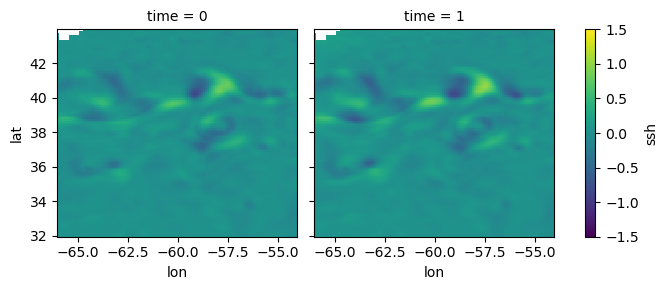

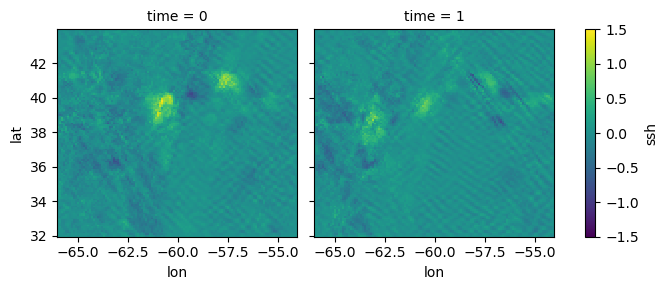

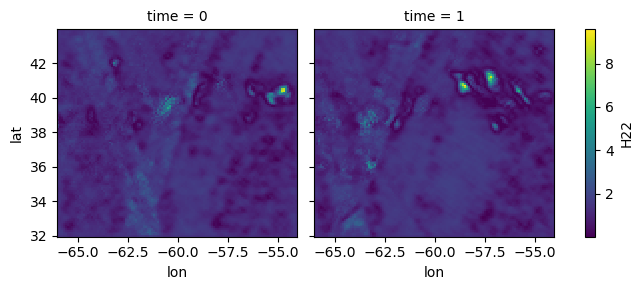

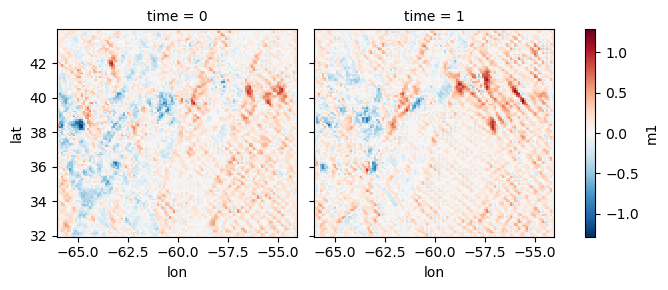

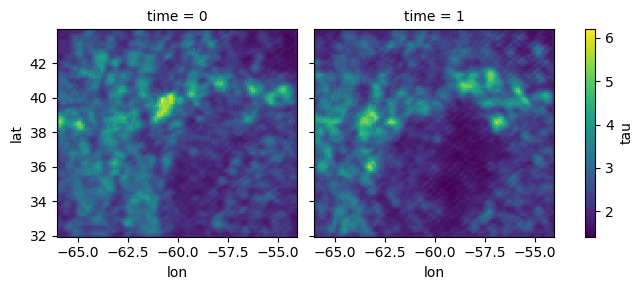

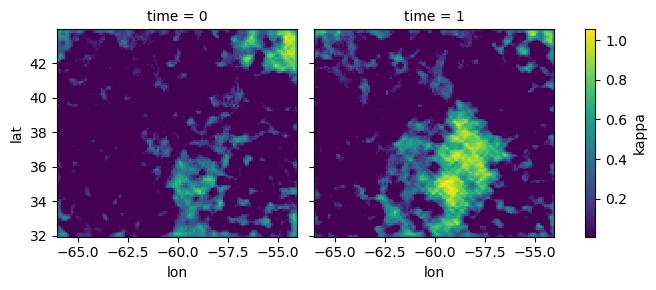

In [31]:
# test
#ckpt = torch.load('ckpt_spde_woi_wonll.pth', map_location=device)
#solver.load_state_dict(ckpt)
 
k = 2
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))
print(test_batch[0].shape)

test_batch = test_batch._replace(input=(test_batch.input-test_batch.oi).to(device))
test_batch = test_batch._replace(tgt=(test_batch.tgt-test_batch.oi).to(device))
#loss, out, theta = base_step(test_batch)
out, _ = solver2(test_batch)
out, theta = solver(test_batch, x_init=out)
    
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[:,4,:,:].detach().cpu())},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-1.5,vmax=1.5)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[:,4,:,:].detach().cpu())},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-1.5,vmax=1.5)
xr.Dataset(data_vars={'H22':(('time','lat','lon'),np.reshape(theta[2][:,1,1,:,4].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).H22.plot(col='time')
xr.Dataset(data_vars={'m1':(('time','lat','lon'),np.reshape(theta[1][:,0,:,4].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).m1.plot(col='time')
xr.Dataset(data_vars={'tau':(('time','lat','lon'),np.reshape(theta[3][:,0,:,4].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).tau.plot(col='time')
xr.Dataset(data_vars={'kappa':(('time','lat','lon'),np.reshape(theta[0][:,0,:,4].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).kappa.plot(col='time')
clear_output(wait=True) 
plt.show()
#print(x_estim.shape)

In [32]:
from IPython.display import clear_output
from sksparse.cholmod import cholesky
import scipy 

downsamp = 4
down = torch.nn.AvgPool2d(downsamp)
up = torch.nn.UpsamplingBilinear2d(scale_factor=downsamp)

def sparse_torch2scipy(A):
    B = scipy.sparse.csc_matrix((A.coalesce().values(),
                         A.coalesce().indices()),
                         shape=(A.size()[0],A.size()[0]),dtype=np.float64)
    return B

def run_simulation(i,tau,M,x,dx,dy,dt,n_init_run=10):
    nb_nodes = M.shape[0]
    regul = (tau*np.sqrt(dt))/(dx*dy)
    val = cupy.fromDlpack(to_dlpack(M.coalesce().values().data))
    ind = cupy.fromDlpack(to_dlpack(M.coalesce().indices().data))
    M_ = cupy_sp_csc_matrix((val,ind),shape=(M.size()[0],M.size()[0]))
    # if i==0: start stability run
    if i==0:
        xi = torch.randn(nb_nodes).to(device)
        for i in range(n_init_run):
            random = torch.randn(nb_nodes).to(device)
            RM = torch.mul(regul,random)+torch.flatten(xi)
            RM_ = cupy.fromDlpack(to_dlpack(RM))
            xi_ = cupy_spsolve(M_, RM_)
            xi = torch.flatten(from_dlpack(xi_.toDlpack())).to(device)
            #xi = torch.flatten(cupy_solve_sparse.apply(M,RM)).to(device)     
    else:
        random = torch.randn(nb_nodes).to(device)
        RM = torch.mul(regul,random)+torch.flatten(x[i-1])
        RM_ = cupy.fromDlpack(to_dlpack(RM))
        xi_ = cupy_spsolve(M_, RM_)
        xi = torch.flatten(from_dlpack(xi_.toDlpack())).to(device)
        #xi = torch.flatten(cupy_solve_sparse.apply(M,RM)).to(device)
    xi.requires_grad = True
    xi = torch.flatten(xi)
    x.append(xi)
    return x

n_b, n_t, n_y, n_x = out.shape
nb_nodes = n_x*n_y
dx = dy = dt = 1


# run n_simu non-conditional simulation
I = sparse_eye(nb_nodes)
pow=2./2


if solver.nll.downsamp is not None:
    spde = Prior_SPDE([n_t,n_y//solver.nll.downsamp,n_x//solver.nll.downsamp],st_lag=[1,
                                                                                      solver.nll.operator_spde.dx,
                                                                                      solver.nll.operator_spde.dy],
                  pow=pow,spde_type='adv_diff',scheme="FUDM1")    
    theta[0],theta[1],theta[2],theta[3] = solver.nll.downsamp_params(theta[0],theta[1],theta[2],theta[3],
                                                         sp_dims=[n_y, n_x])
else:
    spde = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,solver.nll.operator_spde.dx,
                                              solver.nll.operator_spde.dy],
                  pow=pow,spde_type='adv_diff',scheme="FUDM1")
    
Q = spde(theta[0],theta[1],theta[2],theta[3],
         store_block_diag=False)

if solver.nll.downsamp is not None:
    theta[0],theta[1],theta[2],theta[3]  = solver.nll.upsamp_params(theta[0],theta[1],theta[2],theta[3] ,
                                                          sp_dims=[n_y//solver.nll.downsamp, 
                                                                   n_x//solver.nll.downsamp])
    
#test1 = pow_diff_operator(Q[0].detach(),pow=2,sparse=True,split=True,n_t=9).coalesce()
#test2 = pow_diff_operator(Q[0].detach(),pow=2,sparse=True).coalesce()
#print(test1.indices()[0]-test2.indices()[0])

#Q[i] = pow_diff_operator(Q[i],pow=pow_,sparse=True)

n_simu = 2
x_simu = []
type_simu="cov"
for ibatch in range(n_b):
    if type_simu=="seq":
        x_simu_ = []
        for _ in range(n_simu):
            simu = []
            for it in range(n_t):
                # A=solver.nll.operator_spde.fdm(
                A = DiffOperator_old(n_x,
                                     n_y,
                                     dx,
                                     dy,
                                     theta[1][ibatch,:,:,it],
                                     theta[2][ibatch,:,:,:,it],
                                     theta[0][ibatch,:,:,it])
                M = I+pow_diff_operator(A,pow=int(2*pow),sparse=True)
                simu = run_simulation(it,theta[3][ibatch,0,:,it],M,
                                                  simu,dx,dy,dt=1,n_init_run=10)
            x_simu_.append(torch.reshape(torch.stack(simu,dim=0),(n_t,n_y,n_x)))
        x_simu.append(torch.stack(x_simu_,dim=3))      
    else:
        Q_ = Q[ibatch].detach().cpu()
        Q_sp = sparse_torch2scipy(Q_)
        factor = cholesky(Q_sp,ordering_method='natural')
        if solver.nll.downsamp is not None:
            RM = factor.apply_P(torch.randn((nb_nodes//(solver.nll.downsamp**2))*n_t,n_simu))
        else:
            RM = factor.apply_P(torch.randn(nb_nodes*n_t,n_simu))
        x_simu_ = torch.FloatTensor(factor.solve_Lt(RM,
                                                    use_LDLt_decomposition=False)).to(device)
        if solver.nll.downsamp is not None:
            x_simu_ = torch.squeeze(torch.stack([solver.nll.up(torch.reshape(x_simu_[:,i],(1,n_t,n_x//solver.nll.downsamp,n_y//solver.nll.downsamp))) for i in range(n_simu)],dim=4),
                                dim=0)
        else:
            x_simu_ = torch.reshape(x_simu_,(n_t,n_x,n_y,n_simu))
        x_simu.append(x_simu_) 
x_simu = torch.stack(x_simu,dim=0).to(device)

# interpolate the simulation based on LSTM-solver
x_simu_cond = []
for i in range(n_simu):
    inputs_simu = x_simu[:,:,:,:,i].clone()
    inputs_obs_simu = x_simu[:,:,:,:,i].clone()
    mask = test_batch.input.isfinite()
    inputs_obs_simu[~mask] = 0.
    # create simu_batch (with normalization)
    simu_batch = test_batch
    m_simu, s_simu = torch.nanmean(x_simu), torch.std(x_simu)
    simu_batch = simu_batch._replace(input=(inputs_obs_simu-m_simu)/s_simu)
    simu_batch = simu_batch._replace(tgt=(inputs_simu-m_simu)/s_simu)
    #x_itrp_simu, _ = solver(batch=simu_batch)
    x_itrp_simu, _ = solver2(simu_batch)
    #x_itrp_simu, theta = solver(simu_batch, x_init=x_itrp_simu.detach())
    mean = up(down(out))
    x_itrp_simu, _ = solver(simu_batch, 
                            x_init=x_itrp_simu)
    x_itrp_simu = x_itrp_simu.detach()*s_simu+m_simu
    #x_simu = (x_simu.detach()-m_simu)/s_simu
    # conditional simulation
    x_simu_cond_ = out+(x_simu[:,:,:,:,i]-x_itrp_simu)
    x_simu_cond.append(x_simu_cond_)
    
x_simu_cond = torch.stack(x_simu_cond,dim=4).to(device)

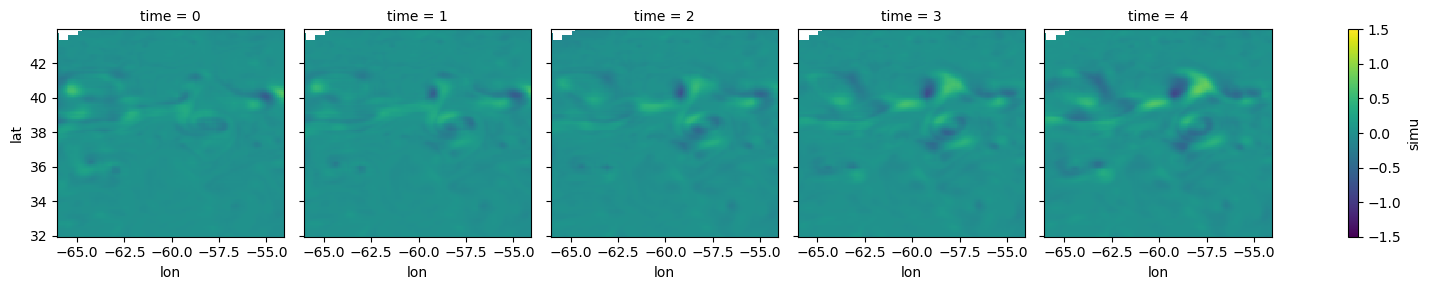

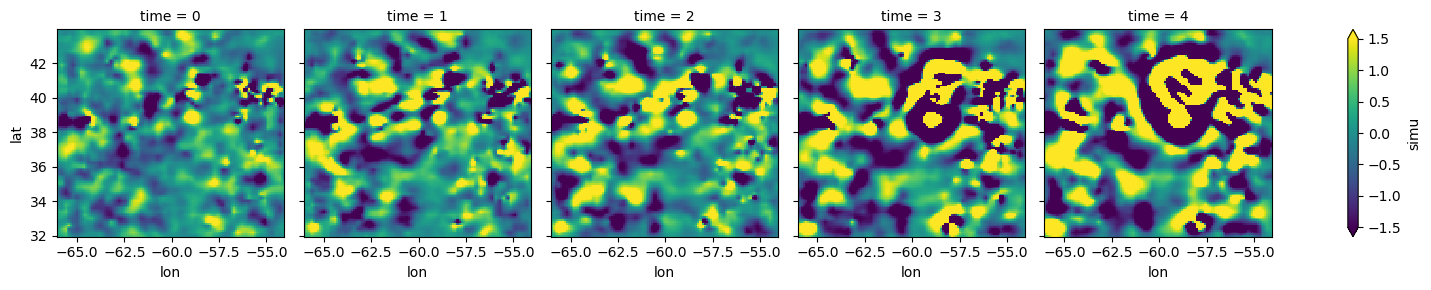

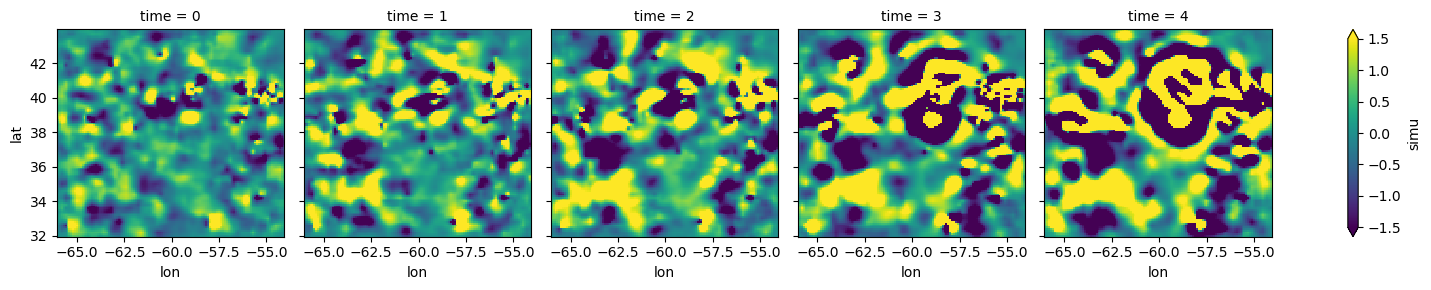

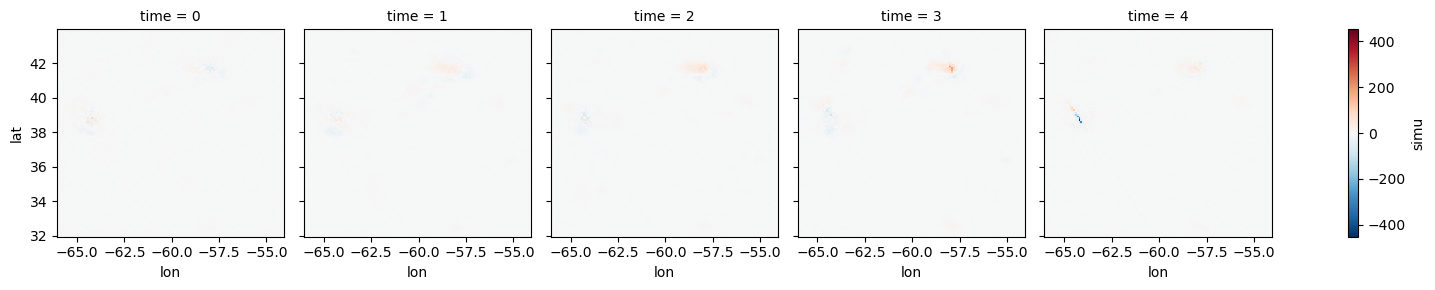

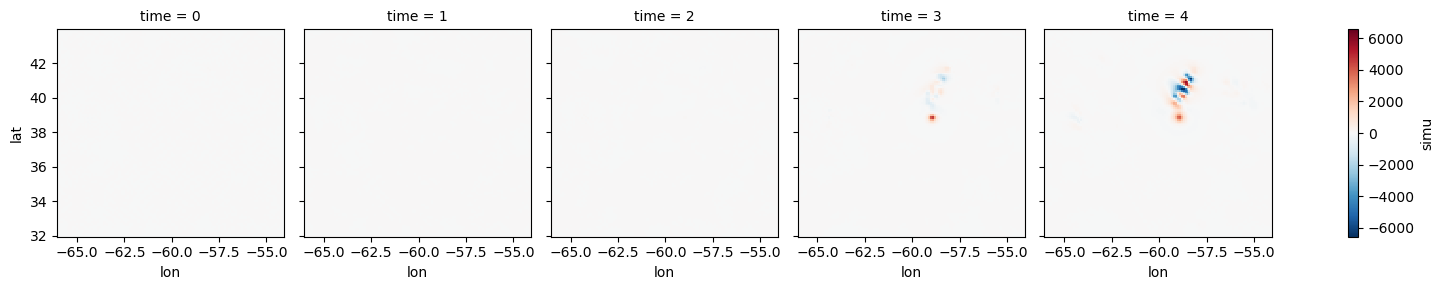

In [34]:
from IPython.display import clear_output

print(theta[3].shape)

xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(test_batch.tgt[:1,:5,:,:].detach().cpu(),(5,120,120)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(vmin=-1.5,vmax=1.5,col='time')#
clear_output(wait=True)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:1,:5,:,:,0].detach().cpu(),(5,120,120)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5,)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:1,:5,:,:,1].detach().cpu(),(5,120,120)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5,)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_itrp_simu[:1,:5,:,:].detach().cpu(),(5,120,120)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time')
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu_cond[:1,:5,:,:,1].detach().cpu(),(5,120,120)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time')
plt.show()

# Test likelihood

In [12]:
# True theta used for simulation
true_nll = solver.nll(test_batch.tgt, theta, mu = None, det=True)

# False theta used for simulation
theta_ = []
theta_.append(theta[0].clone())
theta_.append(theta[1].clone())
theta_.append(theta[2].clone())
theta_.append(theta[3].clone())
theta_[0] = torch.full(theta_[0].shape,0.2).to(device)
theta_[1][:,0,:,:] = 10.
theta_[1][:,1,:,:] = 0.
theta_[2][:,0,0,:,:] = 200.
theta_[2][:,0,1,:,:] = 0.
theta_[2][:,1,0,:,:] = 0.
theta_[2][:,1,1,:,:] = 2.
theta_[3][:,1,1,:,:] = 2*(torch.abs(kfilts.spatial_gradient(test_batch.tgt,normalized=True)[:,:,1,:,:]))+.01
false_nll = solver.nll(test_batch.tgt, theta_, mu = None, det=True)

print(true_nll, false_nll)

tensor([nan, nan], device='cuda:0', grad_fn=<MulBackward0>) tensor([nan, nan], device='cuda:0', grad_fn=<MulBackward0>)
